# 패키지 설치

In [1]:
!pip install torch torchvision numpy matplotlib tensorboard thop

# 데이터셋 준비(CIFAR-10)

In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# CIFAR-10 데이터 전처리 및 로드 (이미지 크기 유지)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# CIFAR-10 데이터셋 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:08<00:00, 20.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn

class LightweightVGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Adaptive Average Pooling
            nn.AdaptiveAvgPool2d((1, 1)),  # Always outputs (256, 1, 1)
        )

        # Classifier Block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),  # 256 is the number of channels after AdaptiveAvgPool2d
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10),  # For CIFAR-10 classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [4]:
!pip install ptflops

In [52]:
from ptflops import get_model_complexity_info

# 1. 프루닝된 모델 불러오기
# 프루닝된 모델 정의
model = LightweightVGG16()

# 저장된 프루닝된 모델에서 가중치만 로드
pruned_model_path = "/content/saved_models/lightweight_vgg16.pth"
checkpoint = torch.load(pruned_model_path)
model.load_state_dict(checkpoint["model_state_dict"])  # 가중치만 로드

# 2. FLOPs와 파라미터 수 계산
with torch.cuda.device(0):  # GPU 사용 (CUDA)
    macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=True, verbose=True)

# 결과 출력
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")

LightweightVGG16(
  3.82 M, 100.000% Params, 79.49 MMac, 99.747% MACs, 
  (features): Sequential(
    3.68 M, 96.422% Params, 79.36 MMac, 99.575% MACs, 
    (0): Conv2d(896, 0.023% Params, 917.5 KMac, 1.151% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.082% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 32.77 KMac, 0.041% MACs, inplace=True)
    (3): Conv2d(9.25 k, 0.242% Params, 9.47 MMac, 11.883% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.082% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(0, 0.000% Params, 32.77 KMac, 0.041% MACs, inplace=True)
    (6): MaxPool2d(0, 0.000% Params, 32.77 KMac, 0.041% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(18.5 k, 0.484% Params, 4.73 MMac, 5.941% MACs, 32, 64,

<ipython-input-52-2e4543ac8be6>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pruned_model_path)


# 모델 설정 및 기본 학습

In [6]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision.models import VGG16_BN_Weights
import torch.optim as optim

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [7]:
# 초기 성능 평가
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 초기 성능 평가
initial_loss, initial_acc = evaluate(model, test_loader, criterion, device)
print(f"초기 성능: Loss = {initial_loss:.4f}, Accuracy = {initial_acc * 100:.2f}%")

초기 성능: Loss = 2.3029, Accuracy = 10.00%


In [11]:
import os

# 모델 저장 경로
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, "lightweight_vgg16.pth")

# 학습 코드
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

# 학습 및 평가 루프
epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = 0.0  # 최적의 성능 저장용 변수

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{epochs}]: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc * 100:.2f}%, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc * 100:.2f}%")

    # 모델 저장 (최적의 Validation Accuracy를 기준으로)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc,
        }, model_save_path)
        print(f"Model saved at epoch {epoch} with Val Acc = {val_acc * 100:.2f}%")

print(f"Training complete. Best Val Acc = {best_val_acc * 100:.2f}%")


Epoch [1/20]: Train Loss = 0.2588, Train Acc = 90.99%, Val Loss = 0.4116, Val Acc = 86.95%
Model saved at epoch 1 with Val Acc = 86.95%
Epoch [2/20]: Train Loss = 0.2544, Train Acc = 91.30%, Val Loss = 0.4384, Val Acc = 85.85%
Epoch [3/20]: Train Loss = 0.2444, Train Acc = 91.52%, Val Loss = 0.4156, Val Acc = 86.89%
Epoch [4/20]: Train Loss = 0.2333, Train Acc = 92.03%, Val Loss = 0.4084, Val Acc = 86.95%
Epoch [5/20]: Train Loss = 0.2249, Train Acc = 92.32%, Val Loss = 0.3848, Val Acc = 88.20%
Model saved at epoch 5 with Val Acc = 88.20%
Epoch [6/20]: Train Loss = 0.2151, Train Acc = 92.57%, Val Loss = 0.4152, Val Acc = 87.33%
Epoch [7/20]: Train Loss = 0.2102, Train Acc = 92.83%, Val Loss = 0.4100, Val Acc = 86.98%
Epoch [8/20]: Train Loss = 0.2043, Train Acc = 92.99%, Val Loss = 0.4034, Val Acc = 87.89%
Epoch [9/20]: Train Loss = 0.1990, Train Acc = 93.15%, Val Loss = 0.3927, Val Acc = 87.64%
Epoch [10/20]: Train Loss = 0.1876, Train Acc = 93.46%, Val Loss = 0.3911, Val Acc = 87.81%

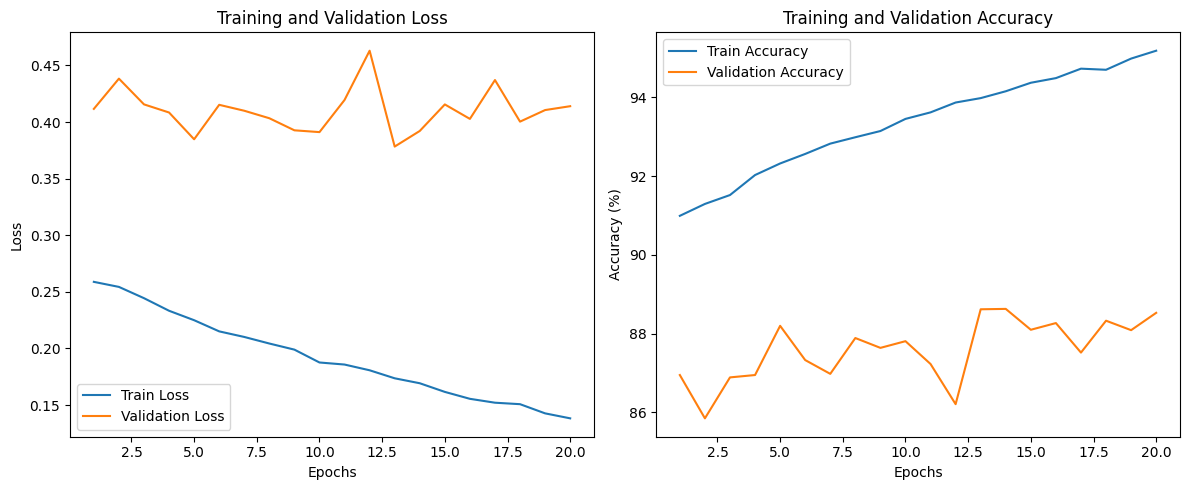

In [12]:
import matplotlib.pyplot as plt

# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), [acc * 100 for acc in train_accs], label='Train Accuracy')
plt.plot(range(1, epochs + 1), [acc * 100 for acc in val_accs], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 필터 중요도 계산 및 프루닝

In [13]:
import copy
import torch.nn.utils.prune as prune

# 1. L1-norm 기반 필터 중요도 계산 함수
def calculate_filter_importance(layer):
    # L1-norm으로 필터 중요도 계산
    importance = torch.sum(torch.abs(layer.weight.data), dim=(1, 2, 3))
    return importance

# 2. Structured Pruning 및 Accuracy 평가
def structured_pruning_and_evaluation(model, test_loader, prune_ratios, device):
    layerwise_accuracy = {}
    original_weights = {}

    # 모든 Conv2d 레이어에 대해 순회
    for layer_idx, module in enumerate(model.features):
        if isinstance(module, nn.Conv2d):
            print(f"\nPruning Layer {layer_idx}...")
            layerwise_accuracy[f"Layer {layer_idx}"] = []
            original_weights[layer_idx] = module.weight.data.clone()  # 원본 가중치 저장

            # Pruning 비율별로 반복
            for ratio in prune_ratios:
                # 중요도 계산 및 필터 선택
                importance = calculate_filter_importance(module)
                num_filters = module.weight.size(0)
                num_to_prune = int(num_filters * ratio)
                prune_indices = torch.argsort(importance)[:num_to_prune]  # 낮은 중요도의 필터 선택

                # Pruning
                mask = torch.ones(num_filters, dtype=torch.bool, device=device)
                mask[prune_indices] = False
                module.weight.data[~mask] = 0.0  # Prune된 필터의 가중치를 0으로 설정

                # Accuracy 평가
                acc = evaluate_model(model, test_loader, device)
                print(f"Pruning Ratio {ratio*100:.0f}% - Accuracy: {acc:.2f}%")
                layerwise_accuracy[f"Layer {layer_idx}"].append(acc)

                # Pruning 후 복원
                module.weight.data = original_weights[layer_idx].clone()

    return layerwise_accuracy

    # 3. 모델 평가 함수
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

In [16]:
# LightweightVGG16 모델 정의
model = LightweightVGG16()

# 저장된 체크포인트에서 가중치만 로드
checkpoint = torch.load("/content/saved_models/lightweight_vgg16.pth")
model.load_state_dict(checkpoint["model_state_dict"])  # 모델의 가중치만 로드
model = model.to(device)

print("Model weights loaded successfully.")


Model weights loaded successfully.


<ipython-input-16-bd931dfdb573>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/saved_models/lightweight_vgg16.pth")


In [17]:
# Pruning 비율 정의
prune_ratios = [0.1 * i for i in range(1, 10)]  # 10%, 20%, ..., 90%

# Pruning 및 Accuracy 평가 실행
layerwise_accuracy = structured_pruning_and_evaluation(model, test_loader, prune_ratios, device)



Pruning Layer 0...
Pruning Ratio 10% - Accuracy: 87.90%
Pruning Ratio 20% - Accuracy: 87.18%
Pruning Ratio 30% - Accuracy: 86.84%
Pruning Ratio 40% - Accuracy: 85.69%
Pruning Ratio 50% - Accuracy: 83.13%
Pruning Ratio 60% - Accuracy: 76.72%
Pruning Ratio 70% - Accuracy: 61.13%
Pruning Ratio 80% - Accuracy: 47.81%
Pruning Ratio 90% - Accuracy: 30.43%

Pruning Layer 3...
Pruning Ratio 10% - Accuracy: 82.65%
Pruning Ratio 20% - Accuracy: 83.64%
Pruning Ratio 30% - Accuracy: 83.64%
Pruning Ratio 40% - Accuracy: 62.38%
Pruning Ratio 50% - Accuracy: 58.03%
Pruning Ratio 60% - Accuracy: 50.07%
Pruning Ratio 70% - Accuracy: 43.73%
Pruning Ratio 80% - Accuracy: 28.93%
Pruning Ratio 90% - Accuracy: 17.14%

Pruning Layer 7...
Pruning Ratio 10% - Accuracy: 77.48%
Pruning Ratio 20% - Accuracy: 69.40%
Pruning Ratio 30% - Accuracy: 41.84%
Pruning Ratio 40% - Accuracy: 34.09%
Pruning Ratio 50% - Accuracy: 21.02%
Pruning Ratio 60% - Accuracy: 17.55%
Pruning Ratio 70% - Accuracy: 15.34%
Pruning Ratio 8

<ipython-input-21-5a412bc01a8f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_layers)  # 색상 맵 (tab10은 10개 색상 지원)


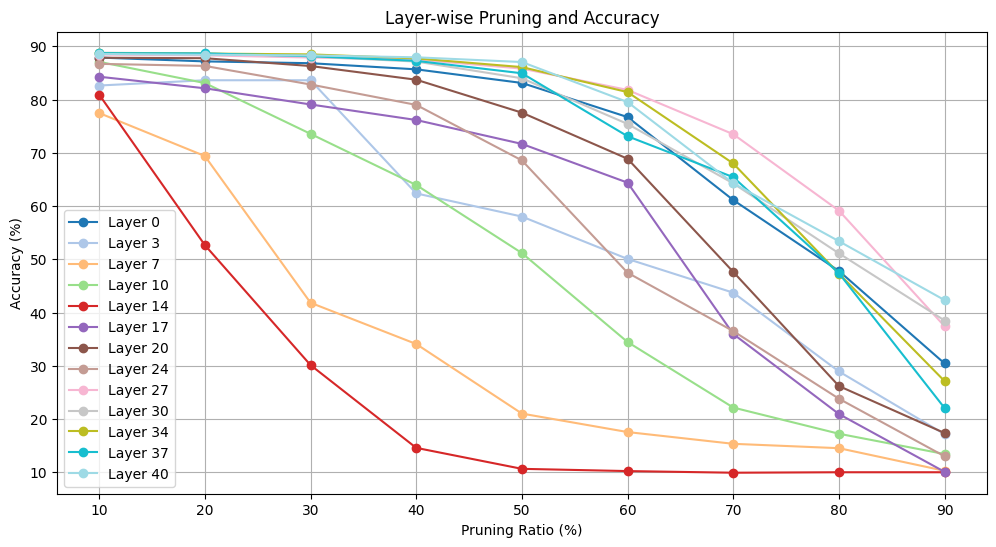

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm

def visualize_pruning_results(layerwise_accuracy, prune_ratios):
    plt.figure(figsize=(12, 6))

    num_layers = len(layerwise_accuracy)  # 레이어 개수
    colormap = cm.get_cmap('tab20', num_layers)  # 색상 맵 (tab20은 20개 색상 지원)

    for idx, (layer, accuracies) in enumerate(layerwise_accuracy.items()):
        plt.plot(
            [ratio * 100 for ratio in prune_ratios],
            accuracies,
            marker='o',
            label=layer,
            color=colormap(idx)  # 색상 맵에서 색상 가져오기
        )

    plt.xlabel("Pruning Ratio (%)")
    plt.ylabel("Accuracy (%)")
    plt.title("Layer-wise Pruning and Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# 호출
visualize_pruning_results(layerwise_accuracy, prune_ratios)


# 재학습 및 성능 평가

In [33]:
# 2. 재학습 함수
def retrain_model(pruned_model, train_loader, criterion, optimizer, epochs, device):
    pruned_model.train()
    for epoch in range(epochs):
        total_loss, total_correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = pruned_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {total_loss:.4f}, Accuracy: {100.0 * total_correct / len(train_loader.dataset):.2f}%")


In [34]:
# 3. 프루닝 및 재학습 포함 평가
def structured_pruning_with_retraining(model, train_loader, test_loader, prune_ratios, criterion, optimizer, epochs, device):
    layerwise_accuracy = {}
    original_weights = {}

    # Conv2D 레이어 순회
    for layer_idx, module in enumerate(model.features):
        if isinstance(module, nn.Conv2d):
            print(f"\nPruning Layer {layer_idx}...")
            layerwise_accuracy[f"Layer {layer_idx}"] = []
            original_weights[layer_idx] = module.weight.data.clone()  # 원본 가중치 저장

            # Pruning 비율별로 반복
            for ratio in prune_ratios:
                # 중요도 계산 및 필터 선택
                importance = calculate_filter_importance(module)
                num_filters = module.weight.size(0)
                num_to_prune = int(num_filters * ratio)
                prune_indices = torch.argsort(importance)[:num_to_prune]  # 중요도가 낮은 필터 선택

                # 프루닝
                mask = torch.ones(num_filters, dtype=torch.bool, device=device)
                mask[prune_indices] = False
                module.weight.data[~mask] = 0.0  # 프루닝된 필터의 가중치를 0으로 설정

                # 모델 복사 및 재학습
                pruned_model = copy.deepcopy(model)
                retrain_model(pruned_model, train_loader, criterion, optimizer, epochs, device)

                # 평가
                acc = evaluate_model(pruned_model, test_loader, device)
                print(f"Pruning Ratio {ratio*100:.0f}% - Accuracy: {acc:.2f}%")
                layerwise_accuracy[f"Layer {layer_idx}"].append(acc)

                # 원래 가중치 복원
                module.weight.data = original_weights[layer_idx].clone()

    return layerwise_accuracy


# 결과 시각화 및 분석



Pruning Layer 0...
Epoch [1/1] - Loss: 212.4630, Accuracy: 84.33%
Pruning Ratio 10% - Accuracy: 81.66%
Epoch [1/1] - Loss: 207.8701, Accuracy: 84.40%
Pruning Ratio 20% - Accuracy: 81.50%
Epoch [1/1] - Loss: 211.4746, Accuracy: 84.03%
Pruning Ratio 30% - Accuracy: 81.78%
Epoch [1/1] - Loss: 211.3889, Accuracy: 84.29%
Pruning Ratio 40% - Accuracy: 81.80%
Epoch [1/1] - Loss: 212.6068, Accuracy: 84.21%
Pruning Ratio 50% - Accuracy: 81.60%
Epoch [1/1] - Loss: 209.8106, Accuracy: 84.17%
Pruning Ratio 60% - Accuracy: 81.85%
Epoch [1/1] - Loss: 210.9499, Accuracy: 84.30%
Pruning Ratio 70% - Accuracy: 81.64%
Epoch [1/1] - Loss: 259.0890, Accuracy: 81.59%
Pruning Ratio 80% - Accuracy: 79.65%
Epoch [1/1] - Loss: 569.3386, Accuracy: 67.56%
Pruning Ratio 90% - Accuracy: 69.75%

Pruning Layer 3...
Epoch [1/1] - Loss: 226.1191, Accuracy: 83.53%
Pruning Ratio 10% - Accuracy: 81.23%
Epoch [1/1] - Loss: 262.4026, Accuracy: 81.52%
Pruning Ratio 20% - Accuracy: 80.26%
Epoch [1/1] - Loss: 289.1269, Accura

<ipython-input-21-5a412bc01a8f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_layers)  # 색상 맵 (tab10은 10개 색상 지원)


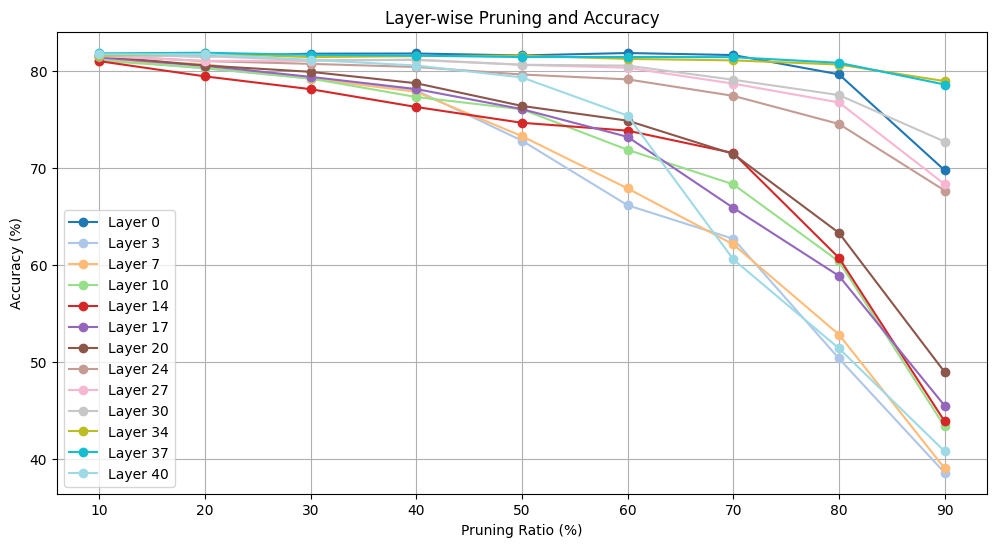

In [36]:
# Pruning 및 재학습 포함 성능 평가
layerwise_accuracy = structured_pruning_with_retraining(
    model, train_loader, test_loader, prune_ratios, criterion, optimizer, epochs=1, device=device
)

# 결과 시각화
visualize_pruning_results(layerwise_accuracy, prune_ratios)


<ipython-input-40-b60ad053ab9b>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_layers)  # 색상 맵 (tab20은 20개 색상 지원)


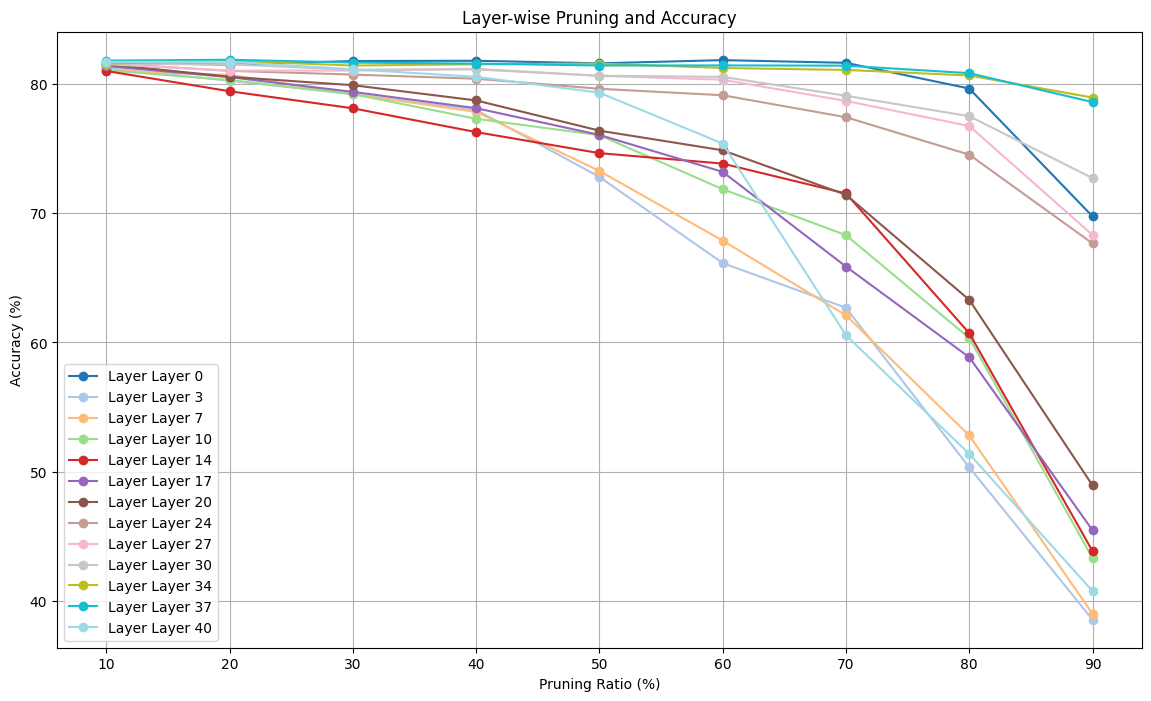

In [40]:
# def plot_pruning_results(layerwise_accuracy, prune_ratios):
#     import matplotlib.pyplot as plt

#     plt.figure(figsize=(14, 8))

#     num_layers = len(layerwise_accuracy)  # 레이어 개수
#     colormap = cm.get_cmap('tab20', num_layers)  # 색상 맵 (tab20은 20개 색상 지원)

#     for idx, (layer, accuracies) in enumerate(layerwise_accuracy.items()):
#         plt.plot(
#             [p * 100 for p in prune_ratios],
#             accuracies,
#             marker='o',
#             label=f"Layer {layer}",
#             color=colormap(idx)  # 색상 맵에서 색상 가져오기
#         )

#     plt.xlabel("Pruning Ratio (%)")
#     plt.ylabel("Accuracy (%)")
#     plt.title("Layer-wise Pruning and Accuracy")
#     plt.legend(loc='lower left')
#     plt.grid(True)
#     plt.show()

# plot_pruning_results(layerwise_accuracy, prune_ratios)


In [43]:
# 프루닝된 모델 저장
torch.save(model.state_dict(), "pruned_model.pth")
